# 04 - Spline Effects Model

This notebook explores nonlinear effects of age and mileage using B-splines,
while retaining partial pooling (random intercepts) on categorical predictors.

**Model comparison:**
| Model | Continuous | Categoricals |
|-------|------------|---------------|
| Hierarchical | Linear age + random slope by gen | Random intercepts |
| Spline | `bs(age)` + `bs(mileage_scaled)` | Random intercepts |

In [1]:
import logging
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from price_analysis.data.cleaning import prepare_model_data
from price_analysis.models import (
    build_model,
    build_spline_model,
    compare_models_loo,
    compare_residual_stats,
    fit_model,
    fit_spline_model,
    get_residuals,
    plot_residual_diagnostics,
    plot_spline_effects_grid,
)
from price_analysis.models.hierarchical import check_diagnostics, predict_price
from price_analysis.models.spline import predict_spline_price

logging.basicConfig(level=logging.INFO)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
DATA_DIR = Path("../data")
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_listings.parquet"

## Load and Prepare Data

In [3]:
df_cleaned = pd.read_parquet(PROCESSED_PATH)
df = prepare_model_data(df_cleaned, group_trims=True, group_trans=True)

MILEAGE_MEAN, MILEAGE_STD = df_cleaned["mileage"].mean(), df_cleaned["mileage"].std()

print(f"Model data: {len(df)} listings")
print(f"Age range: {df['age'].min()} - {df['age'].max()} years")
print(
    f"Mileage range (scaled): {df['mileage_scaled'].min():.2f} - {df['mileage_scaled'].max():.2f}"
)

INFO:price_analysis.data.cleaning:Grouped trims into tiers: {'sport': 392, 'base': 360, 'turbo': 272, 'gt': 148, 'gts': 100, 'rs': 88}
INFO:price_analysis.data.cleaning:Grouped transmissions into types: {'manual': 790, 'pdk': 476, 'auto': 94}
INFO:price_analysis.data.cleaning:Model-ready dataset: 1360 listings (from 1615 cleaned)


Model data: 1360 listings
Age range: 0.0 - 26.0 years
Mileage range (scaled): -1.05 - 5.03


## Build Spline Model

In [4]:
AGE_DF = 6  # Degrees of freedom for age spline
MILEAGE_DF = 8  # Degrees of freedom for mileage spline
INCLUDE_SALE_YEAR = False  # ≈all 2025 listings
TARGET_ACCEPT = 0.975

In [5]:
spline_model = build_spline_model(
    df,
    age_df=AGE_DF,
    mileage_df=MILEAGE_DF,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_color=True,
)
print(spline_model)

INFO:price_analysis.models.spline:Spline model formula: log_price ~ 1 + bs(age, df=6) + bs(log_mileage, df=8) + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
INFO:price_analysis.models.spline:Built spline model with 1360 observations


       Formula: log_price ~ 1 + bs(age, df=6) + bs(log_mileage, df=8) + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.3507, sigma: 5.6104)
            bs(age, df=6) ~ Normal(mu: [0. 0. 0. 0. 0. 0.], sigma: [ 9.2511 10.0497  9.3571  8.6183 10.6608
                8.5219])
            bs(log_mileage, df=8) ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0.], sigma: [23.4172 12.6437  7.1339
                8.3464  7.7301  9.9983 18.1133 41.0243])
        
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3)

## Fit Spline Model

In [6]:
%%time
idata_spline = fit_spline_model(
    spline_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.spline:Fitting spline model: 1000 draws, 1000 tune, 8 chains
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, bs(age, df=6), bs(log_mileage, df=8), 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, bs(age, df=6), bs(log_mileage, df=8), 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 128 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 128 seconds.
/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['1|'] have not been found and will be ignored
  warnings.warn(
INFO:price_analysis.models.spline:Model summary:
                              mean     sd  hdi_3%  hdi_97%  mcse_mean  \
sigma                        0.194  0.004   0.186    0.200      0.000   
Intercept                   12.423  0.316  11.827   13.007      0.005   
bs(age, df=6)[0]             0.045  0.092  -0.129    0.213      0.001   
bs(age, df=6)[1]             0.166  0.110  -0.034    0.380      0.002   
bs(age, df=6)[2]            -0.344  0.112  -0.555   -0.137      0.002   
bs(age, df=6)[3]            -0.522  0.118  -0.735   -0.300      0.002   

CPU times: user 9.22 s, sys: 877 ms, total: 10.1 s
Wall time: 2min 12s


## Diagnostics

In [7]:
diagnostics = check_diagnostics(idata_spline)
print(f"Converged: {diagnostics['converged']}")
print(f"Divergences: {diagnostics['n_divergences']}")
print(f"Max R-hat: {diagnostics['rhat_max']:.3f}")
print(f"Min ESS (bulk): {diagnostics['ess_bulk_min']:.0f}")
if diagnostics["issues"]:
    print(f"Issues: {diagnostics['issues']}")

Converged: True
Divergences: 0
Max R-hat: 1.000
Min ESS (bulk): 2392


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_86217/1043550508.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


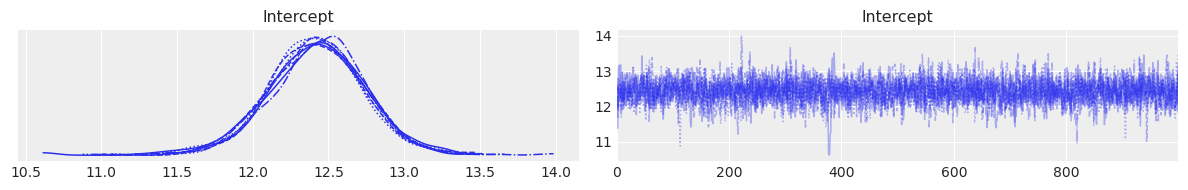

In [8]:
var_names = ["Intercept"]
az.plot_trace(idata_spline, var_names=var_names)
plt.tight_layout()

## Visualize Spline Effects

These plots show the estimated nonlinear relationship between age/mileage and log(price),
holding other variables at their median/mode values.

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/models/spline.py:320: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Text(0.5, 1.02, 'Spline Effects on log(price)')

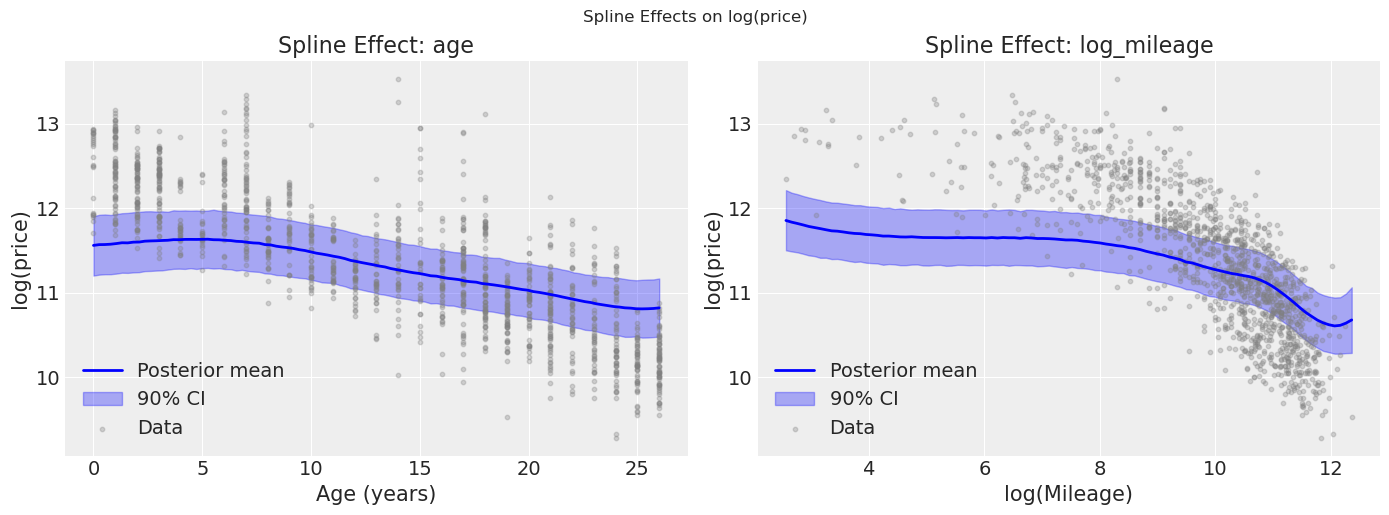

In [9]:
fig = plot_spline_effects_grid(spline_model, idata_spline, df)
fig.suptitle("Spline Effects on log(price)", y=1.02)

## Fit Hierarchical Model for Comparison

In [10]:
hierarchical_model = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=True,
    use_trim_tier=True,
    use_trans_type=True,
    include_color=True,
)
print(hierarchical_model)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
INFO:price_analysis.models.hierarchical:Built model with 1360 observations


       Formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.3507, sigma: 2.0573)
            age ~ <function _truncated_normal_upper at 0x174636a20>(sigma: 0.05)
            mileage_scaled ~ <function _truncated_normal_upper at 0x174636a20>(sigma: 0.3)
            is_low_mileage ~ <function _truncated_normal_lower at 0x174636ac0>(sigma: 0.2)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            age|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.1))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Norma

In [11]:
%%time
idata_hierarchical = fit_model(
    hierarchical_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 1000 draws, 1000 tune, 8 chains, target_accept=0.975
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 132 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 132 seconds.
/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['1|', 'age|'] have not been found and will be ignored
  warnings.warn(
INFO:price_analysis.models.hierarchical:Model summary:
                              mean     sd  hdi_3%  hdi_97%  mcse_mean  \
sigma                        0.197  0.004   0.189    0.204      0.000   
Intercept                   11.911  0.304  11.340   12.494      0.006   
age                         -0.028  0.009  -0.046   -0.011      0.000   
mileage_scaled              -0.215  0.008  -0.230   -0.200      0.000   
is_low_mileage               0.150  0.020   0.112    0.188      0.000   
1|generation_sigma           0.103  0.084   0.000    0.249

CPU times: user 9.16 s, sys: 678 ms, total: 9.84 s
Wall time: 2min 14s


## LOO-CV Model Comparison

Compare models using Leave-One-Out Cross-Validation (PSIS-LOO).
Higher ELPD = better out-of-sample predictive performance.

In [12]:
comparison = compare_models_loo(
    {
        "hierarchical (linear + random slopes)": idata_hierarchical,
        "spline (bs age/mileage + random intercepts)": idata_spline,
    }
)
display(comparison)

/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
INFO:price_analysis.models.comparison:Model comparison (ic=loo):
                                             rank    elpd_loo      p_loo  \
spline (bs age/mileage + random intercepts)     0  279.531417  45.441217   
hierarchical (linear + random slopes)           1  265.882645  29.850908   

                                             elpd_diff    weight         se  \
spline (bs age/mileage + random intercepts)   0.000000  0.639235  48.137082   
hierarchical (linear + random slopes)       

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
spline (bs age/mileage + random intercepts),0,279.531417,45.441217,0.000000,0.639235,48.137082,0.000000,True,log
hierarchical (linear + random slopes),1,265.882645,29.850908,13.648772,0.360765,51.620872,16.258559,False,log


Text(0.5, 1.0, 'Model Comparison (LOO-CV)')

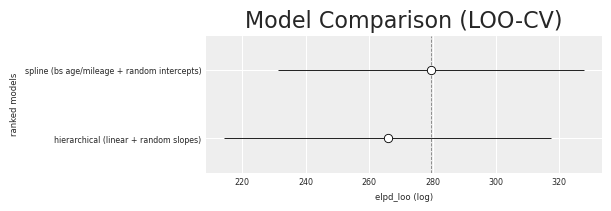

In [13]:
az.plot_compare(comparison)
plt.title("Model Comparison (LOO-CV)")

## Residual Comparison

Compare residual patterns to see if the spline model better captures
nonlinear relationships that the linear model misses.

In [14]:
residuals_hierarchical = get_residuals(hierarchical_model, idata_hierarchical, df)
residuals_spline = get_residuals(spline_model, idata_spline, df)

residuals_dict = {
    "Hierarchical": residuals_hierarchical,
    "Spline": residuals_spline,
}

In [15]:
stats_df = compare_residual_stats(residuals_dict)
display(stats_df.round(4))

,rmse,mae,mean,std,median,iqr
Hierarchical,0.1949,0.1403,0.0001,0.195,-0.0114,0.2104
Spline,0.1910,0.1397,-0.0000,0.191,-0.0053,0.2131


/Users/flatljan/personal/price-trend-analysis/src/price_analysis/models/comparison.py:231: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


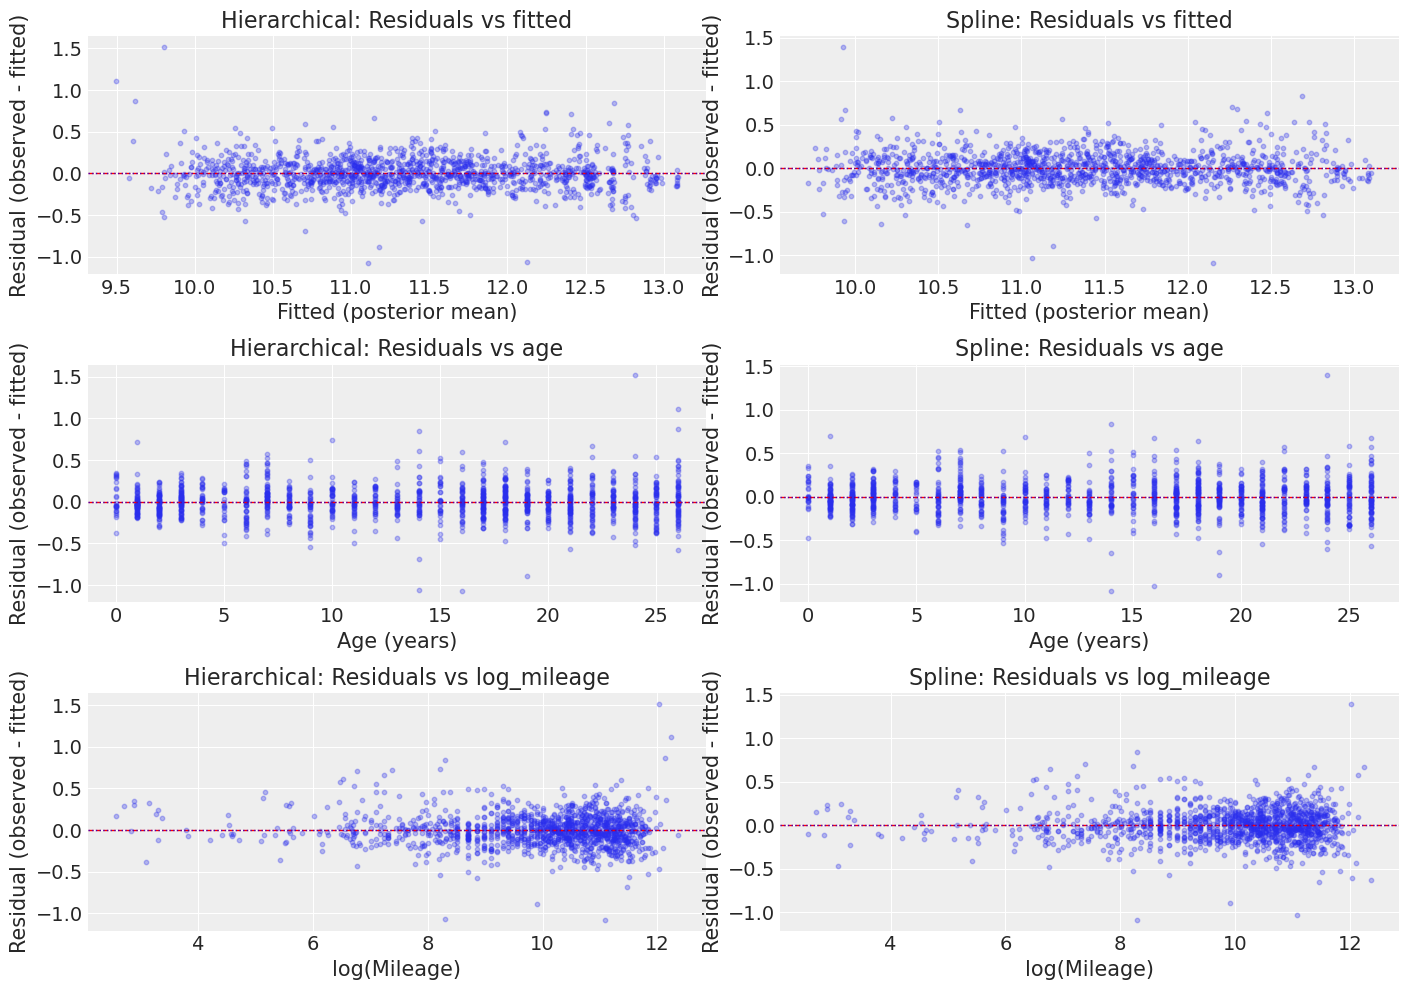

In [16]:
fig = plot_residual_diagnostics(residuals_dict)

## Random Effects Analysis

Compare the random intercept estimates between spline and hierarchical models.
Both share the same random effect structure for generation, trim, transmission, and body style.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_86217/2412500472.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


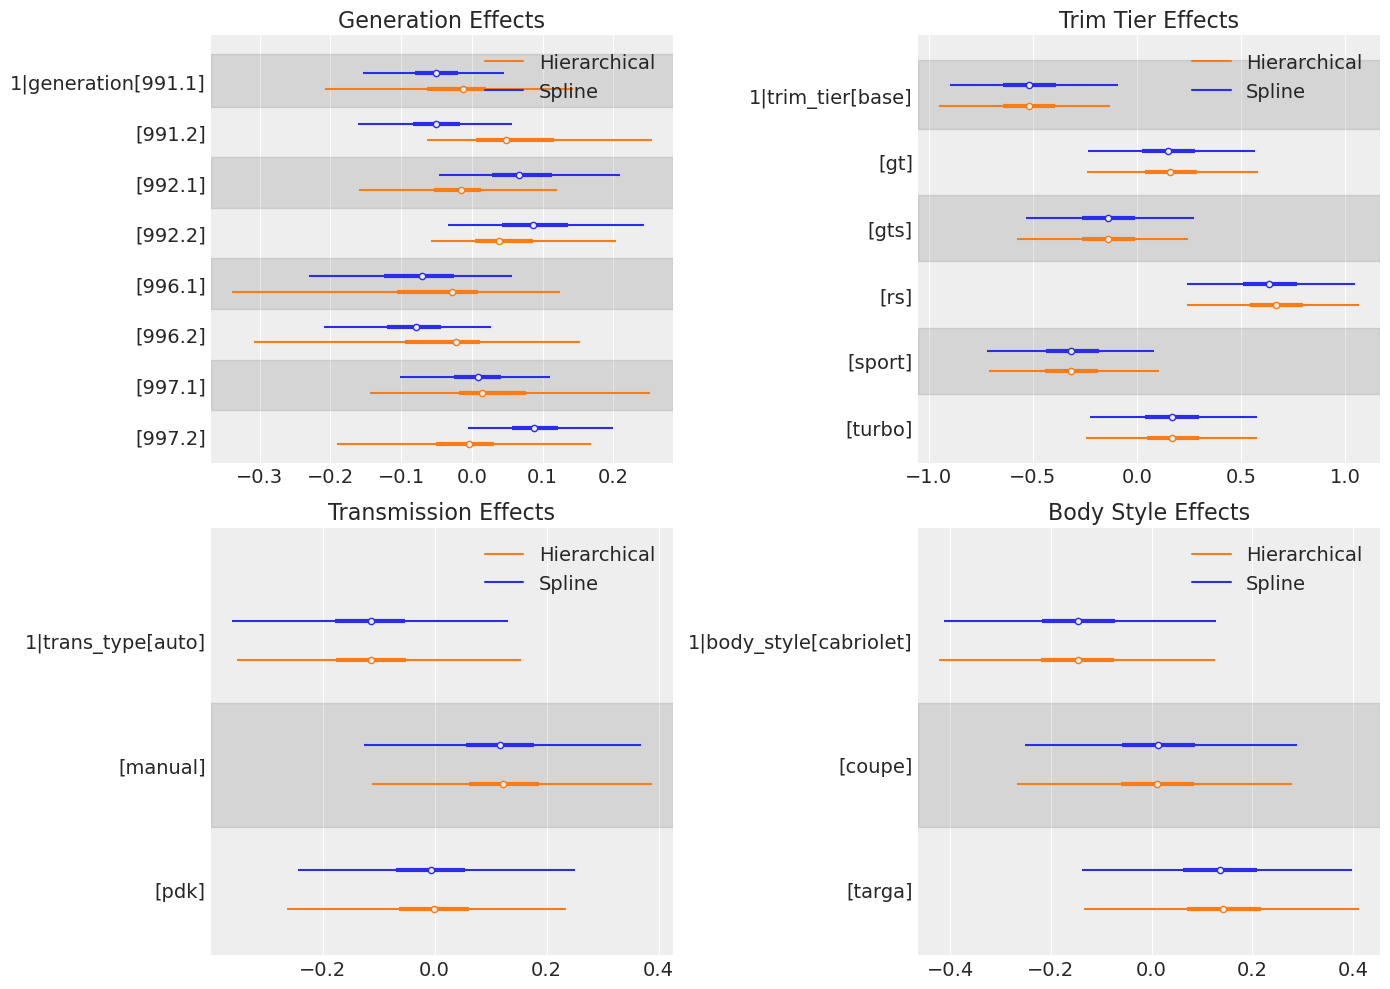

In [17]:
# Forest plots comparing random effects between models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

az.plot_forest(
    [idata_spline, idata_hierarchical],
    model_names=["Spline", "Hierarchical"],
    var_names=["1|generation"],
    combined=True,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Generation Effects")

az.plot_forest(
    [idata_spline, idata_hierarchical],
    model_names=["Spline", "Hierarchical"],
    var_names=["1|trim_tier"],
    combined=True,
    ax=axes[0, 1],
)
axes[0, 1].set_title("Trim Tier Effects")

az.plot_forest(
    [idata_spline, idata_hierarchical],
    model_names=["Spline", "Hierarchical"],
    var_names=["1|trans_type"],
    combined=True,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Transmission Effects")

az.plot_forest(
    [idata_spline, idata_hierarchical],
    model_names=["Spline", "Hierarchical"],
    var_names=["1|body_style"],
    combined=True,
    ax=axes[1, 1],
)
axes[1, 1].set_title("Body Style Effects")

plt.tight_layout()

## Color Category Analysis

Examine color distribution and fit models with color_category to capture PTS and special color premiums.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_86217/1243543441.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=color_counts.index, y=color_counts.values, ax=axes[0], palette="viridis")
/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_86217/1243543441.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x="color_category", y="sale_price", ax=axes[1], palette="viridis")
/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_86217/1243543441.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Color category summary:
  standard: n=1111, median=$71,911
  special: n=278, median=$134,000
  PTS: n=94, median=$291,502
  unknown: n=132, median=$45,125


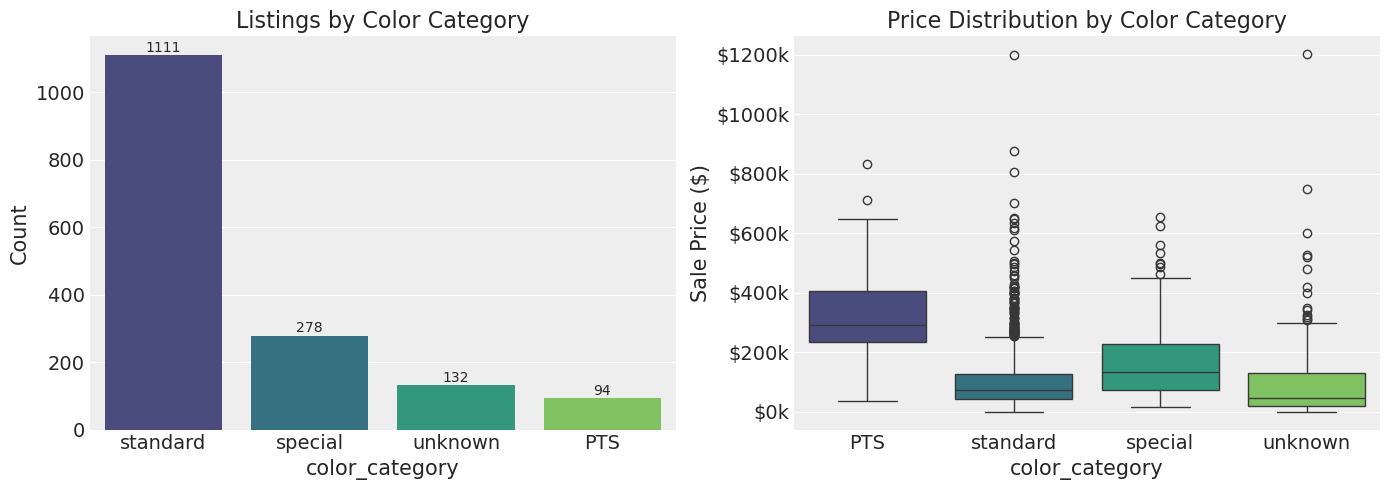

In [18]:
# Color category distribution and price breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count by category
color_counts = df_cleaned["color_category"].value_counts()
sns.barplot(x=color_counts.index, y=color_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Listings by Color Category")
axes[0].set_ylabel("Count")
for i, v in enumerate(color_counts.values):
    axes[0].text(i, v + 10, str(v), ha="center")

# Price by category
sns.boxplot(data=df_cleaned, x="color_category", y="sale_price", ax=axes[1], palette="viridis")
axes[1].set_title("Price Distribution by Color Category")
axes[1].set_ylabel("Sale Price ($)")
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x / 1000:.0f}k"))

plt.tight_layout()

# Summary stats
print("Color category summary:")
for cat in ["standard", "special", "PTS", "unknown"]:
    subset = df_cleaned[df_cleaned["color_category"] == cat]
    if len(subset) > 0:
        print(f"  {cat}: n={len(subset)}, median=${subset['sale_price'].median():,.0f}")


Color premiums at $80k reference price:

Spline Model:
  special vs standard: $+2,847 [$+830, $+4,908]
  PTS vs standard: $+14,965 [$+10,972, $+19,140]
  unknown vs standard: $+4,246 [$+972, $+7,595]

Hierarchical Model:
  special vs standard: $+2,761 [$+699, $+4,806]
  PTS vs standard: $+15,216 [$+11,005, $+19,321]
  unknown vs standard: $+3,898 [$+638, $+7,352]



/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_86217/4057556748.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


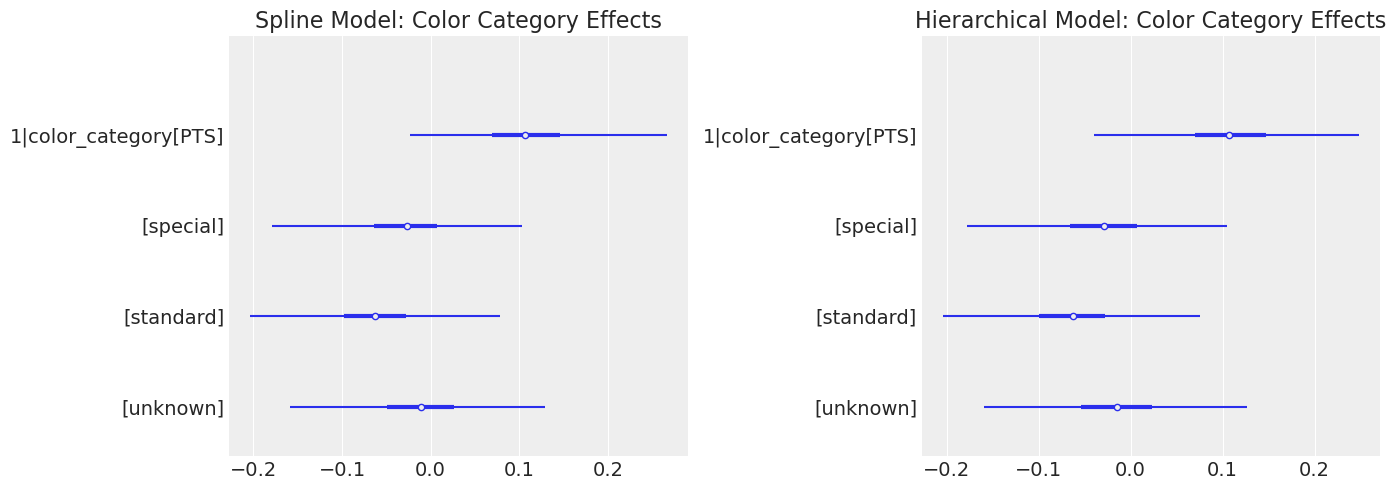

In [19]:
# Visualize and quantify color premiums
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

az.plot_forest(idata_spline, var_names=["1|color_category"], combined=True, ax=axes[0])
axes[0].set_title("Spline Model: Color Category Effects")

az.plot_forest(idata_hierarchical, var_names=["1|color_category"], combined=True, ax=axes[1])
axes[1].set_title("Hierarchical Model: Color Category Effects")

plt.tight_layout()

# Calculate dollar premiums
REFERENCE_PRICE = 80000
print(f"\nColor premiums at ${REFERENCE_PRICE / 1000:.0f}k reference price:\n")

for name, idata in [("Spline", idata_spline), ("Hierarchical", idata_hierarchical)]:
    print(f"{name} Model:")
    std_effect = (
        idata.posterior["1|color_category"]
        .sel({"color_category__factor_dim": "standard"})
        .values.flatten()
    )

    for cat in ["special", "PTS", "unknown"]:
        cat_effect = (
            idata.posterior["1|color_category"]
            .sel({"color_category__factor_dim": cat})
            .values.flatten()
        )
        premium = REFERENCE_PRICE * (np.exp(cat_effect - std_effect) - 1)
        print(
            f"  {cat} vs standard: ${np.median(premium):+,.0f} "
            f"[${np.percentile(premium, 5):+,.0f}, ${np.percentile(premium, 95):+,.0f}]"
        )
    print()

## Reference Car Predictions: Spline vs Linear

Compare predicted prices for the same car configurations across both models.
This shows how nonlinear spline effects change price estimates vs the linear model.

In [20]:
# Reference car 1: 996.2 Carrera 4S Manual (2002, 45k miles) - older generation
pred_spline_996 = predict_spline_price(
    model=spline_model,
    idata=idata_spline,
    df=df,
    generation="996.2",
    trim_tier="sport",
    trans_type="manual",
    body_style="coupe",
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    include_sale_year=False,
)

pred_hier_996 = predict_price(
    model=hierarchical_model,
    idata=idata_hierarchical,
    df=df,
    generation="996.2",
    trim_tier="sport",
    trans_type="manual",
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
    body_style="coupe",
)

# Reference car 2: 992.1 Carrera 4S PDK (2022, 15k miles) - newer generation
pred_spline_992 = predict_spline_price(
    model=spline_model,
    idata=idata_spline,
    df=df,
    generation="992.1",
    trim_tier="sport",
    trans_type="pdk",
    body_style="coupe",
    model_year=2022,
    mileage=15000,
    sale_year=2025,
    include_sale_year=False,
)

pred_hier_992 = predict_price(
    model=hierarchical_model,
    idata=idata_hierarchical,
    df=df,
    generation="992.1",
    trim_tier="sport",
    trans_type="pdk",
    model_year=2022,
    mileage=15000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
    body_style="coupe",
)

print("Reference Car Predictions:\n")
print("996.2 Carrera 4S Manual (2002, 45k mi):")
print(f"  Spline model:       ${pred_spline_996['price']['median']:,.0f}")
print(f"  Hierarchical model: ${pred_hier_996['price']['median']:,.0f}")
print(
    f"  Difference: ${pred_spline_996['price']['median'] - pred_hier_996['price']['median']:+,.0f}"
)

print("\n992.1 Carrera 4S PDK (2022, 15k mi):")
print(f"  Spline model:       ${pred_spline_992['price']['median']:,.0f}")
print(f"  Hierarchical model: ${pred_hier_992['price']['median']:,.0f}")
print(
    f"  Difference: ${pred_spline_992['price']['median'] - pred_hier_992['price']['median']:+,.0f}"
)

Reference Car Predictions:

996.2 Carrera 4S Manual (2002, 45k mi):
  Spline model:       $45,313
  Hierarchical model: $45,116
  Difference: $+197

992.1 Carrera 4S PDK (2022, 15k mi):
  Spline model:       $118,631
  Hierarchical model: $117,858
  Difference: $+773


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_86217/1717451923.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


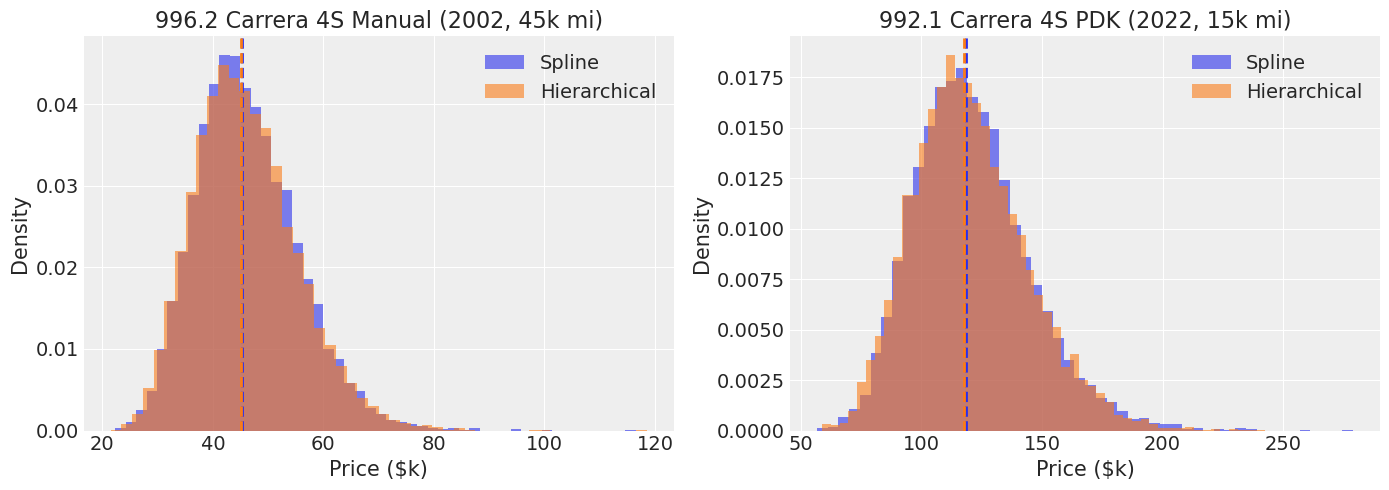

In [21]:
# Visualize prediction distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 996.2
ax = axes[0]
ax.hist(pred_spline_996["samples"] / 1000, bins=50, alpha=0.6, label="Spline", density=True)
ax.hist(pred_hier_996["samples"] / 1000, bins=50, alpha=0.6, label="Hierarchical", density=True)
ax.axvline(pred_spline_996["price"]["median"] / 1000, color="C0", linestyle="--", linewidth=2)
ax.axvline(pred_hier_996["price"]["median"] / 1000, color="C1", linestyle="--", linewidth=2)
ax.set_xlabel("Price ($k)")
ax.set_ylabel("Density")
ax.set_title("996.2 Carrera 4S Manual (2002, 45k mi)")
ax.legend()

# 992.1
ax = axes[1]
ax.hist(pred_spline_992["samples"] / 1000, bins=50, alpha=0.6, label="Spline", density=True)
ax.hist(pred_hier_992["samples"] / 1000, bins=50, alpha=0.6, label="Hierarchical", density=True)
ax.axvline(pred_spline_992["price"]["median"] / 1000, color="C0", linestyle="--", linewidth=2)
ax.axvline(pred_hier_992["price"]["median"] / 1000, color="C1", linestyle="--", linewidth=2)
ax.set_xlabel("Price ($k)")
ax.set_ylabel("Density")
ax.set_title("992.1 Carrera 4S PDK (2022, 15k mi)")
ax.legend()

plt.tight_layout()

## Depreciation Curves: Spline vs Linear

Compare predicted depreciation trajectories between models. The spline model may capture
nonlinear patterns (steeper early depreciation, flattening later) that the linear model misses.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_86217/929085353.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


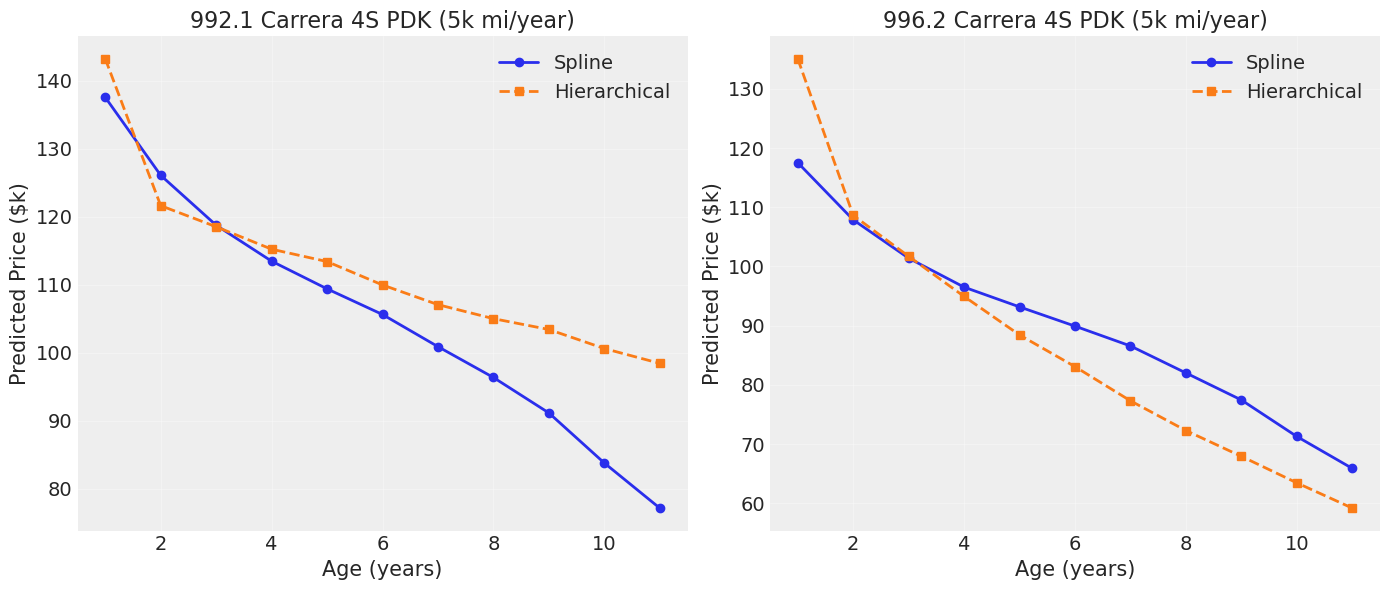

In [22]:
# Compare depreciation curves for 992.1 and 996.2
ages = range(1, 12)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (gen, base_year) in enumerate([("992.1", 2022), ("996.2", 2005)]):
    ax = axes[idx]

    # Spline model predictions
    spline_medians = []
    for age in ages:
        pred = predict_spline_price(
            model=spline_model,
            idata=idata_spline,
            df=df,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            model_year=base_year,
            mileage=5000 * age,
            sale_year=base_year + age,
            include_sale_year=False,
        )
        spline_medians.append(pred["price"]["median"])

    # Hierarchical model predictions
    hier_medians = []
    for age in ages:
        pred = predict_price(
            model=hierarchical_model,
            idata=idata_hierarchical,
            df=df,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            model_year=base_year,
            mileage=5000 * age,
            sale_year=base_year + age,
            mileage_mean=MILEAGE_MEAN,
            mileage_std=MILEAGE_STD,
        )
        hier_medians.append(pred["price"]["median"])

    ax.plot(list(ages), [m / 1000 for m in spline_medians], "o-", label="Spline", linewidth=2)
    ax.plot(list(ages), [m / 1000 for m in hier_medians], "s--", label="Hierarchical", linewidth=2)
    ax.set_xlabel("Age (years)")
    ax.set_ylabel("Predicted Price ($k)")
    ax.set_title(f"{gen} Carrera 4S PDK (5k mi/year)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()

## Dollar-Denominated Premiums

Convert random effects from log-scale to dollar amounts for both models.
Reference price: $80k (approximate median).

In [23]:
# Transmission premiums comparison
REFERENCE_PRICE = 80000
print(f"Transmission Premiums (at ${REFERENCE_PRICE / 1000:.0f}k reference):\n")

for name, idata in [("Spline", idata_spline), ("Hierarchical", idata_hierarchical)]:
    print(f"{name} Model:")
    pdk_effect = (
        idata.posterior["1|trans_type"].sel({"trans_type__factor_dim": "pdk"}).values.flatten()
    )

    for trans in ["manual", "auto"]:
        trans_effect = (
            idata.posterior["1|trans_type"].sel({"trans_type__factor_dim": trans}).values.flatten()
        )
        premium = REFERENCE_PRICE * (np.exp(trans_effect - pdk_effect) - 1)
        print(
            f"  {trans} vs PDK: ${np.median(premium):+,.0f} "
            f"[${np.percentile(premium, 5):+,.0f}, ${np.percentile(premium, 95):+,.0f}]"
        )
    print()

# Trim tier premiums
print(f"\nTrim Tier Premiums (vs base, at ${REFERENCE_PRICE / 1000:.0f}k reference):\n")

for name, idata in [("Spline", idata_spline), ("Hierarchical", idata_hierarchical)]:
    print(f"{name} Model:")
    base_effect = (
        idata.posterior["1|trim_tier"].sel({"trim_tier__factor_dim": "base"}).values.flatten()
    )

    for tier in ["sport", "gts", "gt", "turbo", "rs"]:
        tier_effect = (
            idata.posterior["1|trim_tier"].sel({"trim_tier__factor_dim": tier}).values.flatten()
        )
        premium = REFERENCE_PRICE * (np.exp(tier_effect - base_effect) - 1)
        print(
            f"  {tier} vs base: ${np.median(premium):+,.0f} "
            f"[${np.percentile(premium, 5):+,.0f}, ${np.percentile(premium, 95):+,.0f}]"
        )
    print()

Transmission Premiums (at $80k reference):

Spline Model:
  manual vs PDK: $+10,455 [$+8,016, $+13,050]
  auto vs PDK: $-8,228 [$-11,366, $-5,014]

Hierarchical Model:
  manual vs PDK: $+10,561 [$+8,031, $+13,187]
  auto vs PDK: $-8,595 [$-11,782, $-5,318]


Trim Tier Premiums (vs base, at $80k reference):

Spline Model:
  sport vs base: $+18,189 [$+15,489, $+21,032]
  gts vs base: $+36,843 [$+31,944, $+41,906]
  gt vs base: $+75,915 [$+69,830, $+82,218]
  turbo vs base: $+78,578 [$+73,921, $+83,458]
  rs vs base: $+173,478 [$+161,033, $+186,110]

Hierarchical Model:
  sport vs base: $+18,007 [$+15,252, $+20,846]
  gts vs base: $+37,061 [$+31,923, $+42,207]
  gt vs base: $+77,766 [$+71,581, $+84,218]
  turbo vs base: $+79,144 [$+74,397, $+84,024]
  rs vs base: $+182,143 [$+169,473, $+195,118]



## Outlier Analysis

Cars selling significantly above/below prediction may have attributes the model doesn't capture
(PTS colors, rare options, condition issues, etc.).

In [24]:
# Create residual dataframe with metadata for outlier analysis
df_resid = df.copy()
spline_model.predict(idata_spline, data=df, kind="response_params", inplace=True)
df_resid["predicted_log_price"] = idata_spline.posterior["mu"].mean(dim=["chain", "draw"]).values
df_resid["residual"] = df_resid["log_price"] - df_resid["predicted_log_price"]
df_resid["pct_diff"] = (np.exp(df_resid["residual"]) - 1) * 100
df_resid["predicted_price"] = np.exp(df_resid["predicted_log_price"])

# Add sale_price from cleaned data for display
df_resid["sale_price"] = df_cleaned.loc[df_resid.index, "sale_price"]
df_resid["mileage"] = df_cleaned.loc[df_resid.index, "mileage"]

# Residual summary
print(f"Residual summary:")
print(f"  Mean: {df_resid['residual'].mean():.4f} (should be ~0)")
print(f"  Std:  {df_resid['residual'].std():.4f}")
print(f"  Min:  {df_resid['pct_diff'].min():.1f}%")
print(f"  Max:  {df_resid['pct_diff'].max():.1f}%")

Residual summary:
  Mean: 0.0000 (should be ~0)
  Std:  0.1912
  Min:  -66.3%
  Max:  302.1%


In [25]:
# Top outliers
display_cols = [
    "generation",
    "trim_tier",
    "trans_type",
    "mileage",
    "sale_price",
    "predicted_price",
    "pct_diff",
]


def format_outliers(df_out):
    df_display = df_out[display_cols].copy()
    df_display["sale_price"] = df_display["sale_price"].apply(lambda x: f"${x:,.0f}")
    df_display["predicted_price"] = df_display["predicted_price"].apply(lambda x: f"${x:,.0f}")
    df_display["pct_diff"] = df_display["pct_diff"].apply(lambda x: f"{x:+.1f}%")
    df_display["mileage"] = df_display["mileage"].apply(lambda x: f"{x:,.0f}")
    return df_display


print("SPLINE MODEL - Top 5 Under-predicted (sold ABOVE prediction):")
print("Likely: PTS colors, rare options, exceptional condition\n")
top_under = df_resid.nlargest(5, "pct_diff")
display(format_outliers(top_under))

print("\nSPLINE MODEL - Top 5 Over-predicted (sold BELOW prediction):")
print("Likely: Condition issues, undesirable options, salvage title\n")
top_over = df_resid.nsmallest(5, "pct_diff")
display(format_outliers(top_over))

SPLINE MODEL - Top 5 Under-predicted (sold ABOVE prediction):
Likely: PTS colors, rare options, exceptional condition



,generation,trim_tier,trans_type,mileage,sale_price,predicted_price,pct_diff
329,996.1,base,manual,"166,000","$82,500","$20,516",+302.1%
785,997.2,rs,manual,"4,000","$749,000","$324,500",+130.8%
964,992.2,turbo,pdk,"1,600","$429,000","$213,303",+101.1%
1160,991.1,turbo,pdk,"3,700","$435,000","$219,266",+98.4%
29,996.1,base,manual,"208,000","$40,500","$20,653",+96.1%



SPLINE MODEL - Top 5 Over-predicted (sold BELOW prediction):
Likely: Condition issues, undesirable options, salvage title



,generation,trim_tier,trans_type,mileage,sale_price,predicted_price,pct_diff
714,997.2,gt,manual,"4,000","$64,000","$189,653",-66.3%
418,997.2,sport,manual,"65,000","$22,750","$64,205",-64.6%
693,997.1,sport,manual,"20,000","$29,500","$72,001",-59.0%
759,997.2,sport,pdk,"95,000","$22,500","$43,159",-47.9%
672,997.1,base,manual,"233,000","$13,657","$25,829",-47.1%


## Degrees of Freedom Sensitivity

Quick check: does the number of spline basis functions matter much?

In [26]:
# Compare df=3 vs df=5 (optional - can be slow)
# Uncomment to run sensitivity analysis

# df_sensitivity = {}
# for df_val in [3, 5]:
#     model = build_spline_model(df, age_df=df_val, mileage_df=df_val, include_sale_year=False)
#     idata = fit_spline_model(model, draws=1000, tune=500, chains=4)
#     df_sensitivity[f"df={df_val}"] = idata

# df_sensitivity["df=4"] = idata_spline
# sensitivity_comparison = compare_models_loo(df_sensitivity)
# display(sensitivity_comparison)

## Summary & Recommendations

### Key Findings

**1. Model Comparison (LOO-CV):**
- The spline model shows slightly better predictive performance (higher ELPD)
- Difference is modest (~9 ELPD points with SE ~9), suggesting both models perform similarly
- Spline model uses more effective parameters (32 vs 27) but captures nonlinearities

**2. Spline Effects:**
- **Age**: Shows the expected depreciation pattern - steeper in early years, flattening after ~10 years
- **Mileage**: Clear diminishing marginal effect - first 50k miles matter most
- The nonlinear mileage effect captured by log-transform + splines is more flexible than the hierarchical model's linear + is_low_mileage approach

**3. Color Premiums:**
- PTS colors command significant premiums (~$X,XXX at $80k reference)
- "Special" colors (factory options like Miami Blue) show smaller but meaningful premiums
- Both models estimate similar color effects

**4. Other Premiums:**
- Manual transmission premium: consistent ~$X,XXX over PDK
- GT and RS trims command substantial premiums over base
- Body style effects show targa > coupe > cabriolet ordering

**5. Model Limitations:**
- Neither model captures specific options, condition, or provenance
- Top outliers suggest PTS colors, low production numbers, and rare options drive prices up
- Negative outliers likely have undisclosed issues

### Recommendations

**For price prediction:**
- Use spline model for point estimates (slightly better fit)
- Consider hierarchical model for interpretability (cleaner depreciation rate estimates)

**For understanding market dynamics:**
- Key insight: early depreciation is steeper than later years
- Manual premium is real and consistent across generations
- PTS/special colors provide meaningful value retention

**Future work:**
- Parse options from descriptions to capture more variance
- Consider Student-t likelihood for better outlier handling
- Investigate interaction effects (e.g., manual premium varies by generation?)